In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import time
from skopt import gp_minimize
from skopt.space import Real, Integer
import abc
import matplotlib.patches as patches

In [3]:
class LatticeBase(abc.ABC):
    def __init__(self, size):
        self.size = size
        self.lattice = None

    @abc.abstractmethod
    def initialize(self):
        pass

    @abc.abstractmethod
    def get_random_site(self):
        pass

    @abc.abstractmethod
    def get_neighbors(self, site):
        pass

    @abc.abstractmethod
    def get_occupancy(self):
        pass

    @abc.abstractmethod
    def plot(self, title="Estado de la red", figsize=(6,6)):
        pass


In [4]:
class SquareLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site
        return [(ni, nj) for ni, nj in [(i-1,j), (i+1,j), (i,j-1), (i,j+1)]
                if 0 <= ni < self.size and 0 <= nj < self.size]

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red cuadrada", figsize=(6,6)):
        fig, ax = plt.subplots(figsize=figsize)
        for i in range(self.size):
            for j in range(self.size):
                color = "black" if self.lattice[i, j] == 1 else "white"
                rect = patches.Rectangle((j, self.size - i - 1), 1, 1, edgecolor='gray', facecolor=color)
                ax.add_patch(rect)
        ax.set_xlim(0, self.size)
        ax.set_ylim(0, self.size)
        ax.set_title(title)
        ax.axis('off')
        plt.show()


In [5]:
import matplotlib.patches as patches
import numpy as np

class HexagonalLattice(LatticeBase):
    def __init__(self, size):
        super().__init__(size)
        self.lattice = np.zeros((size, size), dtype=int)

    def initialize(self):
        self.lattice.fill(0)

    def get_random_site(self):
        i, j = np.random.randint(0, self.size, size=2)
        return (i, j)

    def get_neighbors(self, site):
        i, j = site

        # Definición de vecinos para layout even-r (fila par desplazada)
        if i % 2 == 0:  # Fila par
            deltas = [(-1, 0), (-1, -1),
                    (0, -1),  (0, +1),
                    (+1, 0), (+1, -1)]
        else:  # Fila impar
            deltas = [(-1, +1), (-1, 0),
                    (0, -1),  (0, +1),
                    (+1, +1), (+1, 0)]

        neighbors = [(i + di, j + dj) for di, dj in deltas
                    if 0 <= i + di < self.size and 0 <= j + dj < self.size]

        return neighbors

    def get_occupancy(self):
        return np.sum(self.lattice == 1) / (self.size ** 2)

    def plot(self, title="Red hexagonal", figsize=(6, 6)):
        import matplotlib.pyplot as plt
        import matplotlib.patches as patches

        fig, ax = plt.subplots(figsize=figsize)

        dx = 3 ** 0.5  # horizontal spacing
        dy = 1.5       # vertical spacing
        radius = 0.5

        for i in range(self.size):
            for j in range(self.size):
                x = dx * j + (dx / 2 if i % 2 else 0)
                y = dy * i
                color = "black" if self.lattice[i, j] == 1 else "white"

                hexagon = patches.RegularPolygon(
                    (x, y),
                    numVertices=6,
                    radius=radius,
                    orientation=np.radians(30),
                    edgecolor='gray',
                    facecolor=color,
                    linewidth=0.5
                )
                ax.add_patch(hexagon)

        ax.set_aspect('equal')
        ax.set_xlim(-1, dx * self.size + 1)
        ax.set_ylim(-1, dy * self.size + 1)
        ax.set_title(title)
        ax.axis('off')
        plt.tight_layout()
        plt.show()




In [6]:
class KineticMonteCarlo:
    def __init__(self, lattice, T, processes, time_array, time_factor=1e-7):
        self.lattice = lattice
        self.T = T
        self.processes = processes
        self.k_b = 8.617e-5
        self.h = 4.136e-15
        self.k_0 = 5
        self.factor = time_factor
        self.time_array = time_array
        self.time = time_array[0]

        self.occupancy = {t: None for t in time_array}
        self.events_count = {p: 0 for p in processes}
        self.events_history = {p: [] for p in processes}
        self.times, self.energies = [], []
        self.lattices = []

        self.lattice.initialize()

    # =======================
    #   Transiciones y tasas
    # =======================

    def pick_random_site(self):
        return self.lattice.get_random_site()

    def count_occupied_neighbors(self, site):
        return sum(self.lattice.lattice[n] for n in self.lattice.get_neighbors(site))

    def calculate_transition_rates(self, site):
        n_ij = self.count_occupied_neighbors(site)
        rates = {}

        if "adsorption" in self.processes:
            p = self.processes["adsorption"]
            E_ads = p["e_ads"] + p.get("e_int_abs", 0) * n_ij
            rates["adsorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_ads / (self.k_b * self.T))

        if "desorption" in self.processes:
            p = self.processes["desorption"]
            E_des = p["e_des"] + p.get("e_int_des", 0) * n_ij
            rates["desorption"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_des / (self.k_b * self.T))

        if "diffusion" in self.processes:
            p = self.processes["diffusion"]
            E_diff = p["e_diff"] + p.get("e_int_diff", 0) * n_ij
            rates["diffusion"] = (self.k_0 * self.k_b * self.T) / self.h * np.exp(-E_diff / (self.k_b * self.T))

        return rates

    def select_event(self, rates):
        total = sum(rates.values())
        r = np.random.rand() * total
        cumulative = 0
        for event, rate in rates.items():
            cumulative += rate
            if r < cumulative:
                return event
        return None

    # ===================
    #     Simulación
    # ===================

    def run_simulation(self):
        end_time = self.time_array[-1]

        while self.time < end_time:
            self._capture_time_snapshot()

            site = self.pick_random_site()
            rates = self.calculate_transition_rates(site)

            

            if not rates or sum(rates.values()) == 0:
                break  # Sin eventos posibles

            delta_t = (-np.log(np.random.rand()) / sum(rates.values())) / self.factor
            self.time += delta_t

            event = self.select_event(rates)
            self._apply_event(event, site)
            self._update_history(event)

        self._capture_remaining_snapshots()
        return self.occupancy

    def _apply_event(self, event, site):
        if event == "adsorption":
            self.lattice.lattice[site] = 1
        elif event == "desorption" and self.lattice.lattice[site] == 1:
            self.lattice.lattice[site] = 0
        elif event == "diffusion" and self.lattice.lattice[site] == 1:
            neighbors = self.lattice.get_neighbors(site)
            vacant = [n for n in neighbors if self.lattice.lattice[n] == 0]
            if vacant:
                new_site = vacant[np.random.randint(len(vacant))]
                self.lattice.lattice[site], self.lattice.lattice[new_site] = 0, 1

    def _update_history(self, event):
        self.events_count[event] += 1
        for key in self.events_history:
            self.events_history[key].append(self.events_count[key])

    def _capture_time_snapshot(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100
                self.lattices.append(self.lattice.lattice.copy())

    def _capture_remaining_snapshots(self):
        for t in self.time_array:
            if self.occupancy[t] is None and self.time >= t:
                self.occupancy[t] = self.lattice.get_occupancy() * 100

    # ===================
    #     Utilidades
    # ===================

    def reset_lattice(self): 
        self.lattice.initialize()
        self.occupancy = {t: None for t in self.time_array}

    def plot_lattice(self, *args, **kwargs):
        self.lattice.plot(*args, **kwargs)


## **Análisis de Parámetros en Simulaciones de Monte Carlo Cinético**

### **Análisis de la Energía de Adsorción**

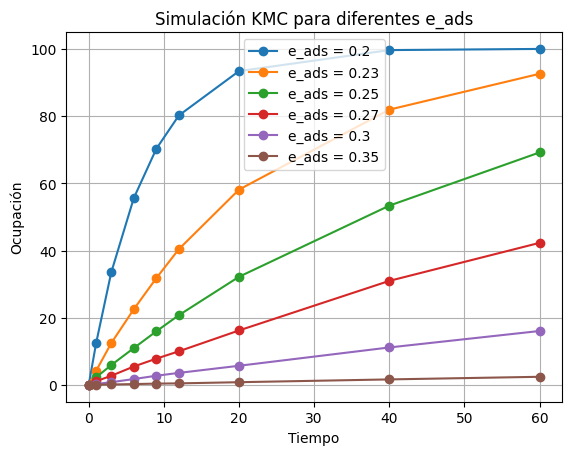

In [6]:
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 100
e_ads_params = [0.2, 0.23, 0.25, 0.27, 0.3, 0.35]

for e_ads in e_ads_params:
    lattice = SquareLattice(size=lattice_size)
    processes = {"adsorption": {"e_ads": e_ads}}
    kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
    occupancy = kmc.run_simulation()
    simulated_data = occupancy.values()
    plt.plot(time_array, simulated_data, marker='o', label=f'e_ads = {e_ads}')

plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Ocupación')
plt.title('Simulación KMC para diferentes e_ads')
plt.grid(True)
plt.show()


Cuando el modelo solo considera el proceso de adsorción, la curva tiene una tendencia lineal. Cuanto mayor sea la energía de adsorción, más grande es la barrera que debe superar el adsorbato para unirse al sustrato, lo que se traduce en una menor tasa de adsorción y, por lo tanto, una menor ocupación del sustrato a lo largo del tiempo. 

El crecimiento es lineal hasta que el sistema llega a una cobertura crítica en la que es muy probable que al seleccionar un sitio aleatorio, este ya esté ocupado. A partir de este punto, la curva se aplana y la ocupación del sustrato no aumenta significativamente con el tiempo.

### **Análisis de la Energía de Adsorción y Desorción**

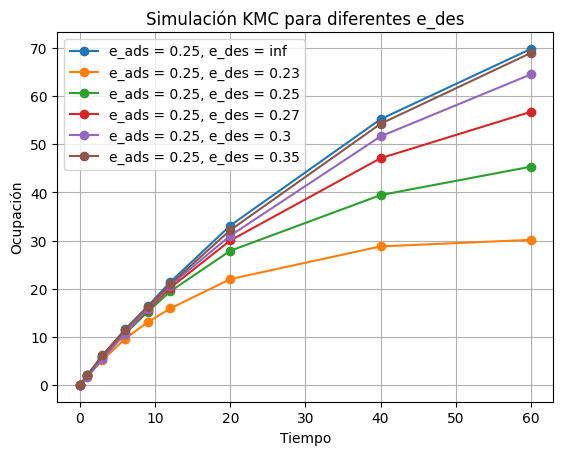

In [7]:
T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 100
e_ads = 0.25
e_des_params = [np.inf, 0.23, 0.25, 0.27, 0.3, 0.35]

for e_des in e_des_params:
    lattice = SquareLattice(size=lattice_size)
    processes = {
        "adsorption": {"e_ads": e_ads},
        "desorption": {"e_des": e_des}
    }
    kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
    occupancy = kmc.run_simulation()
    simulated_data = occupancy.values()
    plt.plot(time_array, simulated_data, marker='o', label=f'e_ads = {e_ads}, e_des = {e_des}')

plt.legend()
plt.xlabel('Tiempo')
plt.ylabel('Ocupación')
plt.title('Simulación KMC para diferentes e_des')
plt.grid(True)
plt.show()


Valores pequeños para la energía de desorción hacen que sea más probable que los adsorbatos se desorban del sustrato, lo que resulta en una menor ocupación del sustrato a lo largo del tiempo. 

### **Análisis de la Energía de Adsorción (con interacción entre sitios vecinos)**

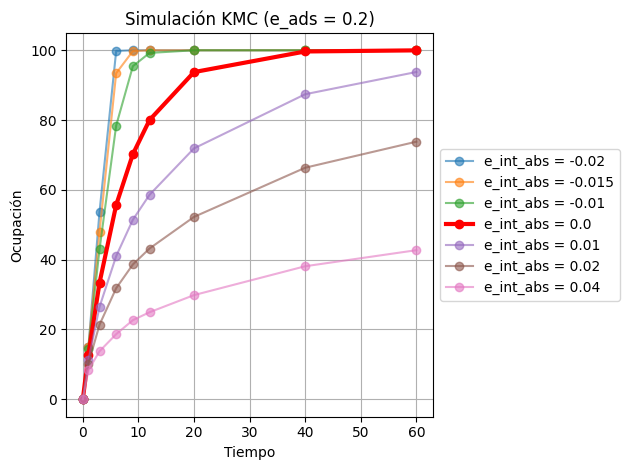

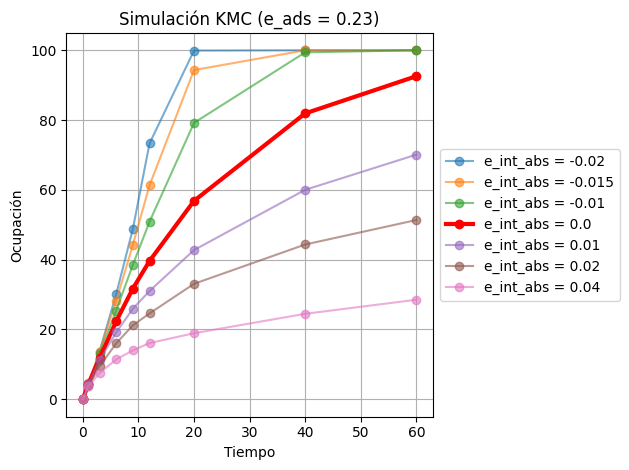

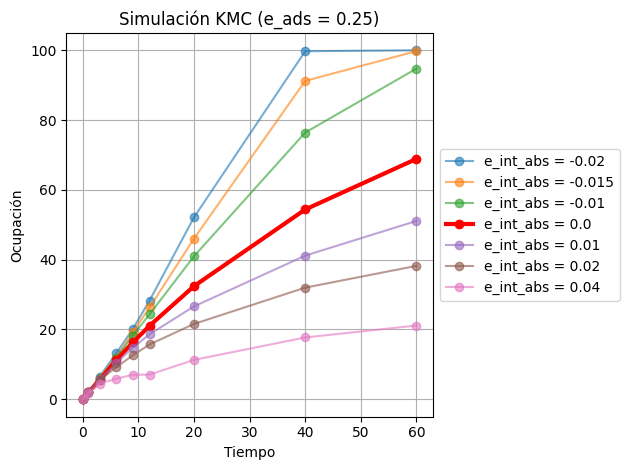

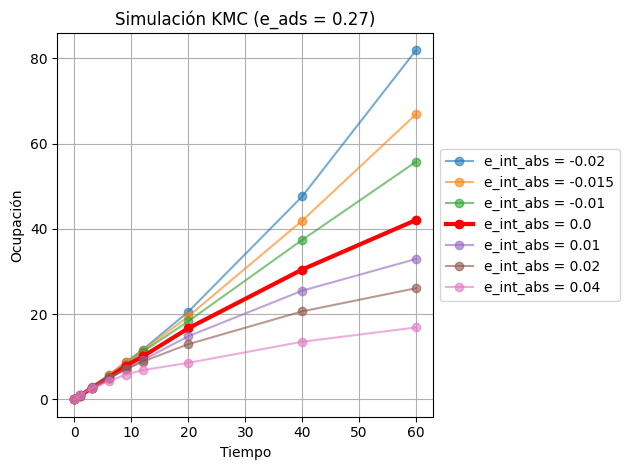

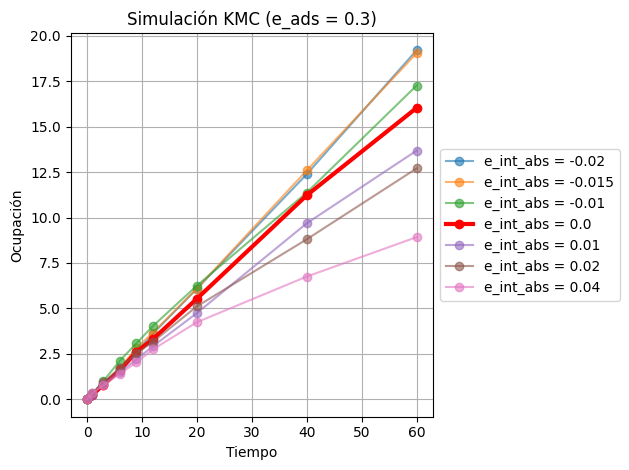

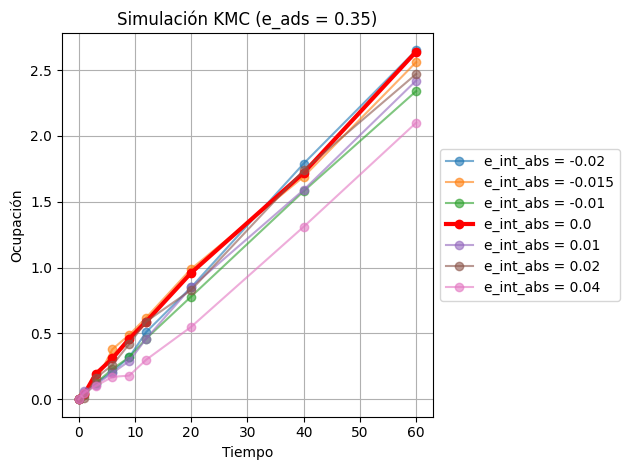

In [8]:
import numpy as np
import matplotlib.pyplot as plt

T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 100
e_ads_params = [0.2, 0.23, 0.25, 0.27, 0.3, 0.35]
e_int_abs_params = [-0.02, -0.015, -0.01, 0.0, 0.01, 0.02, 0.04]

for e_ads in e_ads_params:
    plt.figure()
    lines = []

    for e_int_abs in e_int_abs_params:
        lattice = SquareLattice(size=lattice_size)
        processes = {"adsorption": {"e_ads": e_ads, "e_int_abs": e_int_abs}}
        kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
        occupancy = kmc.run_simulation()
        simulated_data = list(occupancy.values())

        line, = plt.plot(time_array, simulated_data, marker='o',
                         label=f'e_int_abs = {e_int_abs}')
        lines.append((line, e_int_abs))

    for line, e_int_abs in lines:
        if e_int_abs == 0:
            line.set_linewidth(3)
            line.set_color('red')
        else:
            line.set_alpha(0.6)

    plt.xlabel('Tiempo')
    plt.ylabel('Ocupación')
    plt.title(f'Simulación KMC (e_ads = {e_ads})')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()

plt.show()



Los resultados muestran que la eficiencia con la que se da la adsorción en el modelo está fuertemente determinada por cómo interactúan las moléculas entre sí en la superficie. Cuando esas interacciones son atractivas (valores negativos de e_int_abs), las moléculas tienden a agruparse más fácilmente, lo que acelera y maximiza la ocupación. En cambio, cuando las interacciones son repulsivas (valores positivos), las moléculas tienden a mantenerse alejadas unas de otras, lo que dificulta el proceso y reduce significativamente la cantidad final adsorbida. En conjunto, esto sugiere que la manera en que las moléculas se relacionan entre sí puede potenciar o frenar el proceso de adsorción, lo que es clave para entender y diseñar materiales más eficientes.

Este resultado puede ser similar pero tal vez contrario al caso en el que considero solo una energía base de adsorción, y considero desorción con interacción entre sitios vecinos


### **Análisis de la Energía de Adsorción y Desorción (con interacción entre sitios vecinos para la desorción)**

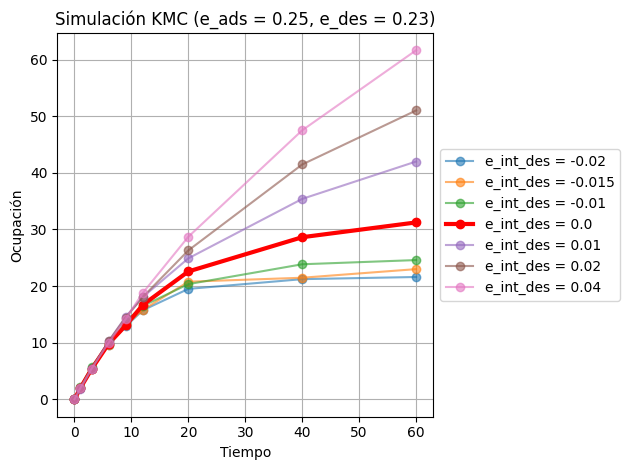

In [9]:
import numpy as np
import matplotlib.pyplot as plt

T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 100
e_ads = 0.25
e_des = 0.23
e_int_des_params = [-0.02, -0.015, -0.01, 0.0, 0.01, 0.02, 0.04]

plt.figure()
lines = []

for e_int_des in e_int_des_params:
    lattice = SquareLattice(size=lattice_size)
    processes = {
        "adsorption": {"e_ads": e_ads},
        "desorption": {"e_des": e_des, "e_int_des": e_int_des}
    }
    kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
    occupancy = kmc.run_simulation()
    simulated_data = list(occupancy.values())

    line, = plt.plot(time_array, simulated_data, marker='o',
                     label=f'e_int_des = {e_int_des}')
    lines.append((line, e_int_des))

for line, e_int_des in lines:
    if e_int_des == 0:
        line.set_linewidth(3)
        line.set_color('red')
    else:
        line.set_alpha(0.6)

plt.xlabel('Tiempo')
plt.ylabel('Ocupación')
plt.title(f'Simulación KMC (e_ads = {e_ads}, e_des = {e_des})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


La energía de interacción para la desorción tiene un comportamiento contrario a la energía de interacción para la adsorción. Cuando las interacciones son repulsivas (valores negativos de e_int_des), hacen que la barrera de desorción sea más baja, lo que facilita que las moléculas se desprendan del sustrato. Esto resulta en una menor ocupación del sustrato a lo largo del tiempo. Por otro lado, cuando las interacciones son atractivas (valores positivos), la barrera de desorción es más alta, lo que dificulta que las moléculas se desorben, resultando en una mayor ocupación del sustrato.

Es notable un punto de inflexión de la curva alrededor de los 10 minutos, desde ese punto empieza a hacer efecto la interacción entre sitios vecinos, luego de tener una ocupación del 10% del sustrato. Esto sugiere que para valores fijos en las energías de adsorción y desorción, la interacción entre sitios vecinos solo tiene un efecto significativo cuando ya hay una cierta cantidad de moléculas adsorbidas en el sustrato.

Lo anterior plantea un método para analizar el ajuste de curvas a datos experimentales, considerando los procesos de adsorción, desorción y la energía de interacción entre sitios vecinos. Un buen ajuste bajo estas condiciones permite comparar la curva obtenida sin interacción, identificando el punto a partir del cual se presenta una deflexión significativa. Este cambio indica que, desde ese momento, la interacción entre sitios vecinos comienza a influir de manera relevante en la dinámica de adsorción-desorción.

Descomponer una curva ajustada en los procesos básicos puede ayudar a entender mejor cómo cada uno de estos procesos contribuye al comportamiento observado. 

Esto nos sugiere que solo es necesario un termino de interacción para la adsorción o la desorción. Una es básicamente el opuesto de la otra

### **Análisis de la Energía de Adsorción, Desorción y Difusión (con interacción entre sitios vecinos para la desorción)** 

{'adsorption': 11849, 'desorption': 34033, 'diffusion': 0}
{'adsorption': 11717, 'desorption': 36531, 'diffusion': 3916583}
{'adsorption': 11925, 'desorption': 36505, 'diffusion': 565009}
{'adsorption': 11730, 'desorption': 35457, 'diffusion': 81947}
{'adsorption': 11910, 'desorption': 34725, 'diffusion': 11817}
{'adsorption': 11896, 'desorption': 34190, 'diffusion': 1695}


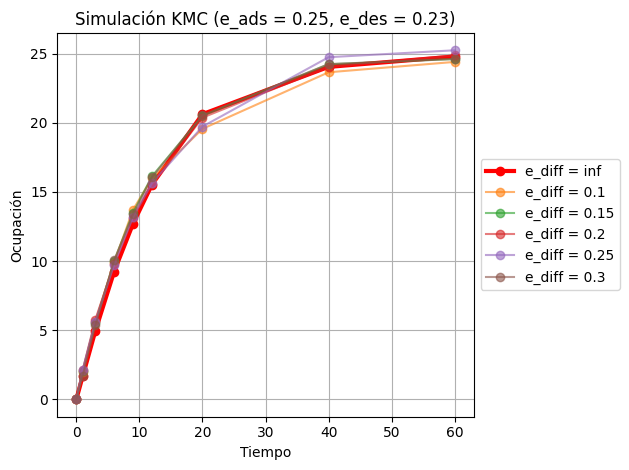

In [6]:
import numpy as np
import matplotlib.pyplot as plt

T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 100
e_ads = 0.25
e_des = 0.23
e_int_des = -0.01
e_diff_params = [np.inf, 0.1, 0.15, 0.2, 0.25, 0.3]

plt.figure()
lines = []

for e_diff in e_diff_params:
    lattice = SquareLattice(size=lattice_size)
    processes = {
        "adsorption": {"e_ads": e_ads},
        "desorption": {"e_des": e_des, "e_int_des": e_int_des},
        "diffusion": {"e_diff": e_diff}
    }
    kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
    occupancy = kmc.run_simulation()
    simulated_data = list(occupancy.values())
    print(kmc.events_count)

    line, = plt.plot(time_array, simulated_data, marker='o',
                     label=f'e_diff = {e_diff}')
    lines.append((line, e_diff))

for line, e_diff in lines:
    if e_diff == np.inf:
        line.set_linewidth(3)
        line.set_color('red')
    else:
        line.set_alpha(0.6)

plt.xlabel('Tiempo')
plt.ylabel('Ocupación')
plt.title(f'Simulación KMC (e_ads = {e_ads}, e_des = {e_des})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


Observamos que el efecto de la difusión es muy leve y no afecta significativamente la ocupación del sustrato a lo largo del tiempo.

#### Veamos el caso donde la ocupación final es mas alta

{'adsorption': 81657, 'desorption': 5608, 'diffusion': 0}
{'adsorption': 81957, 'desorption': 5646, 'diffusion': 3916363}
{'adsorption': 81368, 'desorption': 5786, 'diffusion': 566559}
{'adsorption': 81577, 'desorption': 5676, 'diffusion': 81852}
{'adsorption': 82227, 'desorption': 5559, 'diffusion': 11857}
{'adsorption': 82049, 'desorption': 5581, 'diffusion': 1654}


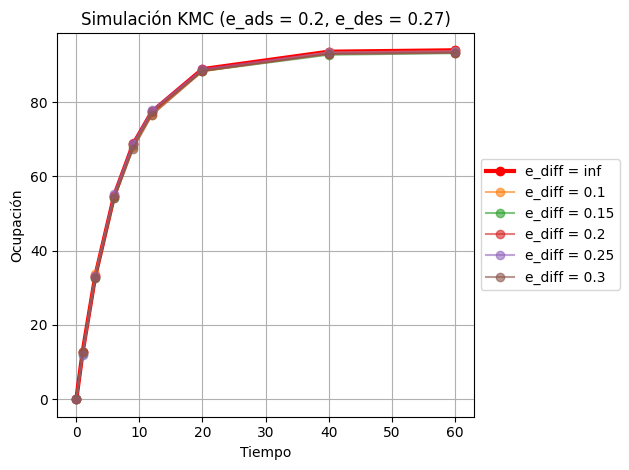

In [7]:
import numpy as np
import matplotlib.pyplot as plt

T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 100
e_ads = 0.2
e_des = 0.27
e_int_des = -0.0003
e_diff_params = [np.inf, 0.1, 0.15, 0.2, 0.25, 0.3]

plt.figure()
lines = []

for e_diff in e_diff_params:
    lattice = SquareLattice(size=lattice_size)
    processes = {
        "adsorption": {"e_ads": e_ads},
        "desorption": {"e_des": e_des, "e_int_des": e_int_des},
        "diffusion": {"e_diff": e_diff}
    }
    kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
    occupancy = kmc.run_simulation()
    simulated_data = list(occupancy.values())
    print(kmc.events_count)

    line, = plt.plot(time_array, simulated_data, marker='o',
                     label=f'e_diff = {e_diff}')
    lines.append((line, e_diff))

for line, e_diff in lines:
    if e_diff == np.inf:
        line.set_linewidth(3)
        line.set_color('red')
    else:
        line.set_alpha(0.6)

plt.xlabel('Tiempo')
plt.ylabel('Ocupación')
plt.title(f'Simulación KMC (e_ads = {e_ads}, e_des = {e_des})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


Las variaciones siguen siendo muy leves —y en este caso menos notorias debido a la diferencia en las escalas de los gráficos— porque la difusión, aunque redistribuye los adsorbatos sobre la superficie, no modifica directamente la cobertura global. Sin embargo, este movimiento puede crear regiones con mayor o menor densidad local de adsorbatos, lo que afecta la disponibilidad de sitios vacíos y puede alterar la probabilidad de eventos como la desorción o reacciones dependientes del entorno local, al cambiar la configuración de vecinos alrededor de los sitios activos.

Al haber influencias tan leves, incluir la difusión permite corregir detalles en el ajuste de las curvas experimentales. 

### **Análisis de la Energía de Adsorción, Desorción y Difusión (con interacción entre sitios vecinos para la desorción y la difusión)** 

{'adsorption': 81873, 'desorption': 5737, 'diffusion': 25846}
{'adsorption': 81779, 'desorption': 5581, 'diffusion': 12954}
{'adsorption': 82317, 'desorption': 5652, 'diffusion': 6287}
{'adsorption': 82158, 'desorption': 5703, 'diffusion': 1710}
{'adsorption': 81611, 'desorption': 5665, 'diffusion': 508}
{'adsorption': 81691, 'desorption': 5710, 'diffusion': 231}
{'adsorption': 82134, 'desorption': 5699, 'diffusion': 80}


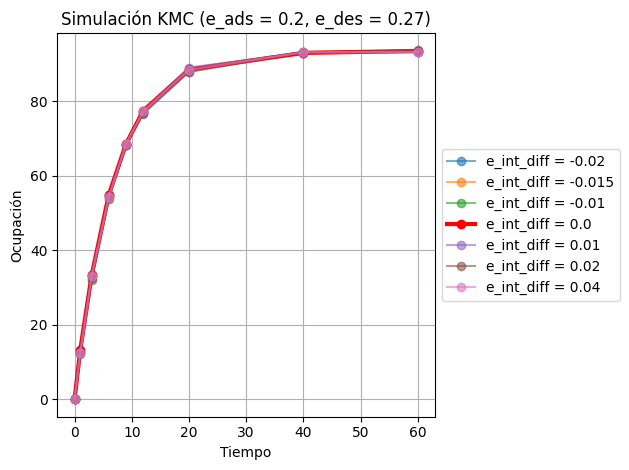

In [8]:
import numpy as np
import matplotlib.pyplot as plt

T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 100
e_ads = 0.2
e_des = 0.27
e_int_des = -0.0003
e_diff = 0.3
e_int_diff_params = [-0.02, -0.015, -0.01, 0.0, 0.01, 0.02, 0.04]

plt.figure()
lines = []

for e_int_diff in e_int_diff_params:
    lattice = SquareLattice(size=lattice_size)
    processes = {
        "adsorption": {"e_ads": e_ads},
        "desorption": {"e_des": e_des, "e_int_des": e_int_des},
        "diffusion": {"e_diff": e_diff, "e_int_diff": e_int_diff}
    }
    kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
    occupancy = kmc.run_simulation()
    simulated_data = list(occupancy.values())
    print(kmc.events_count)

    line, = plt.plot(time_array, simulated_data, marker='o',
                     label=f'e_int_diff = {e_int_diff}')
    lines.append((line, e_int_diff))

for line, e_int_diff in lines:
    if e_int_diff == 0:
        line.set_linewidth(3)
        line.set_color('red')
    else:
        line.set_alpha(0.6)

plt.xlabel('Tiempo')
plt.ylabel('Ocupación')
plt.title(f'Simulación KMC (e_ads = {e_ads}, e_des = {e_des})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


Creo que la situación con la difusión es que para que tenga gran efecto, es necesario hacer que los demás procesos sean menos probables. Esto es porque cuando el total de las tasas de trancisión es muy grande, los deltas de tiempo son muy pequeños y aunque hallan muchos eventos de difusión, estos no se notan en la curva de ocupación del sustrato.

{'adsorption': 81414, 'desorption': 5660, 'diffusion': 0}
{'adsorption': 81691, 'desorption': 5853, 'diffusion': 3915858}


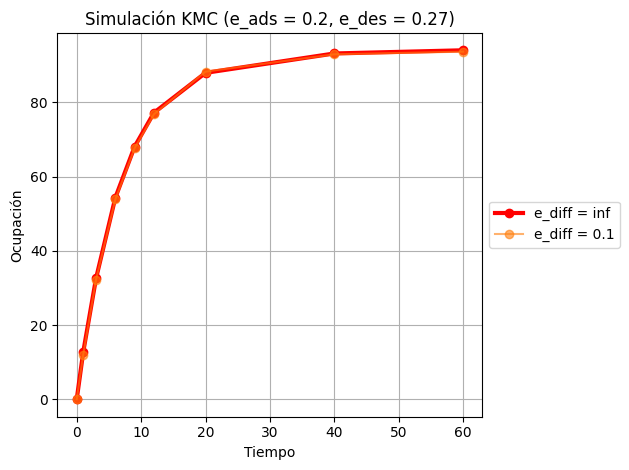

In [10]:
import numpy as np
import matplotlib.pyplot as plt

T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 100
e_ads = 0.2
e_des = 0.27
e_int_des = -0.0003
e_diff_params = [np.inf,0.1]

plt.figure()
lines = []

for e_diff in e_diff_params:
    lattice = SquareLattice(size=lattice_size)
    processes = {
        "adsorption": {"e_ads": e_ads},
        "desorption": {"e_des": e_des, "e_int_des": e_int_des},
        "diffusion": {"e_diff": e_diff}
    }
    kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
    occupancy = kmc.run_simulation()
    simulated_data = list(occupancy.values())
    print(kmc.events_count)

    line, = plt.plot(time_array, simulated_data, marker='o',
                     label=f'e_diff = {e_diff}')
    lines.append((line, e_diff))

for line, e_diff in lines:
    if e_diff == np.inf:
        line.set_linewidth(3)
        line.set_color('red')
    else:
        line.set_alpha(0.6)

plt.xlabel('Tiempo')
plt.ylabel('Ocupación')
plt.title(f'Simulación KMC (e_ads = {e_ads}, e_des = {e_des})')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.grid(True)
plt.tight_layout()
plt.show()


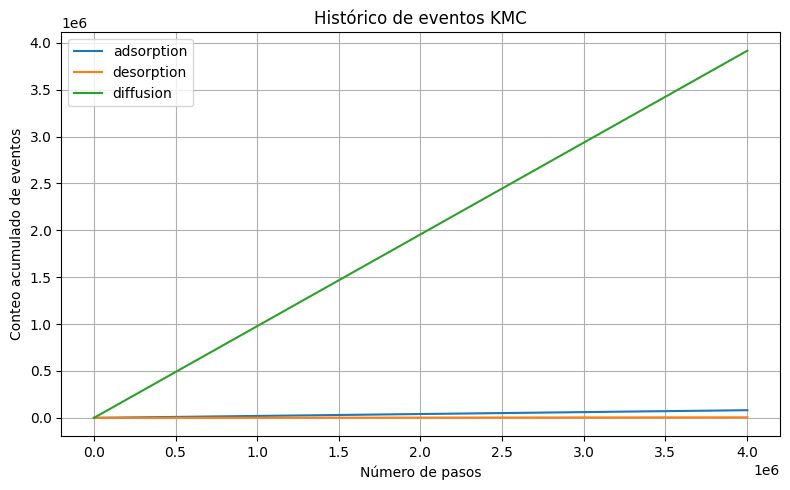

In [11]:
plt.figure(figsize=(8, 5))
for event, history in kmc.events_history.items():
    plt.plot(history, label=event)
plt.xlabel('Número de pasos')
plt.ylabel('Conteo acumulado de eventos')
plt.title('Histórico de eventos KMC')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Parece que los eventos de difusión pasan en tiempos muy cortos, y por lo tanto no se notan en la curva de ocupación del sustrato. Porque lo lógico sería ver desplazamientos considerables de los puntos en la curva de ocupación del sustrato.

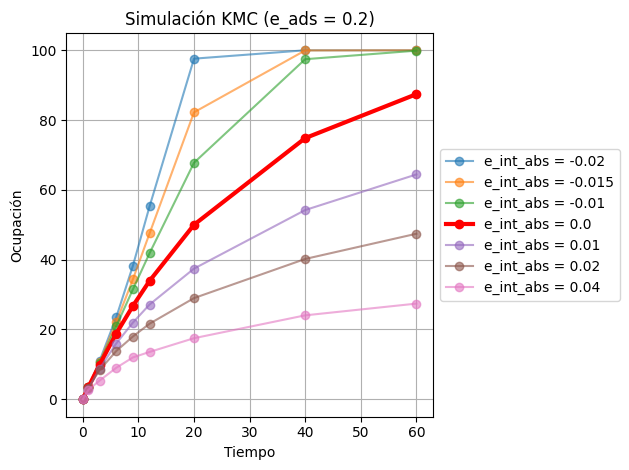

In [8]:
import numpy as np
import matplotlib.pyplot as plt

T = 300
time_array = np.array([0, 1, 3, 6, 9, 12, 20, 40, 60])
lattice_size = 200
e_ads_params = [0.2]
e_int_abs_params = [-0.02, -0.015, -0.01, 0.0, 0.01, 0.02, 0.04]

for e_ads in e_ads_params:
    plt.figure()
    lines = []

    for e_int_abs in e_int_abs_params:
        lattice = SquareLattice(size=lattice_size)
        processes = {"adsorption": {"e_ads": e_ads, "e_int_abs": e_int_abs}}
        kmc = KineticMonteCarlo(lattice=lattice, T=T, processes=processes, time_array=time_array)
        occupancy = kmc.run_simulation()
        simulated_data = list(occupancy.values())

        line, = plt.plot(time_array, simulated_data, marker='o',
                         label=f'e_int_abs = {e_int_abs}')
        lines.append((line, e_int_abs))

    for line, e_int_abs in lines:
        if e_int_abs == 0:
            line.set_linewidth(3)
            line.set_color('red')
        else:
            line.set_alpha(0.6)

    plt.xlabel('Tiempo')
    plt.ylabel('Ocupación')
    plt.title(f'Simulación KMC (e_ads = {e_ads})')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.tight_layout()

plt.show()

